# Proyecto 04 - Reconocimiento de lenguaje de señas

## **Dataset**

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import seaborn as sns
from matplotlib import cm
from collections import Counter
from itertools import product
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import torch
from torch import nn
import torch.optim as optim
import random

### X_data: Matriz de Imágenes

In [2]:
#load
data_test = pd.read_csv('.\data\sign_mnist_test.csv')
data_train = pd.read_csv('.\data\sign_mnist_train.csv')

X_train = data_train.iloc[:, 1:].values / 255.0 # Dividiendo por 255 para normalizar


X_test = data_test.iloc[:, 1:].values / 255.0

X_train

array([[0.41960784, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607843,
        0.79215686],
       [0.60784314, 0.61568627, 0.61176471, ..., 0.40392157, 0.52941176,
        0.58431373],
       [0.73333333, 0.7372549 , 0.7372549 , ..., 0.76470588, 0.76078431,
        0.76470588],
       ...,
       [0.68235294, 0.68235294, 0.68235294, ..., 0.79215686, 0.78431373,
        0.78431373],
       [0.69411765, 0.70980392, 0.72156863, ..., 0.25098039, 0.34117647,
        0.36470588],
       [0.70196078, 0.70588235, 0.70588235, ..., 0.80392157, 0.81960784,
        0.84313725]])

In [3]:
print("Cantidad de pixeles: ", data_test.shape[1]-1)
print("Tamaño de cada imagen: ", np.sqrt(data_test.shape[1]-1), " x ", np.sqrt(data_test.shape[1]-1))
print("Cantidad de imagenes de entrenamiento: ", data_train.shape[0])

Cantidad de pixeles:  784
Tamaño de cada imagen:  28.0  x  28.0
Cantidad de imagenes de entrenamiento:  27455


### Label: etiqueta de cada imagen

In [4]:
y_train = data_train.iloc[:, 0].values
y_test = data_test.iloc[:, 0].values
np.sort(np.sort(data_train['label'].unique()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

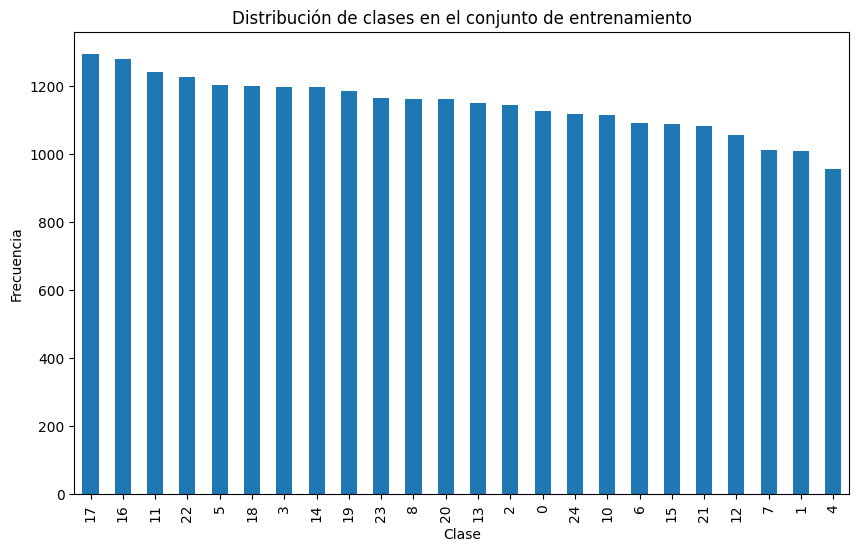

In [5]:
# Conteo de frecuencias de cada clase
train_label_counts = data_train['label'].value_counts()

plt.figure(figsize=(10, 6))
train_label_counts.plot(kind='bar')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

Cada numero representa una letra del abecedario en lenguaje de señas americano (ASL), donde 0 es la letra A y 25 es la letra Z. Debido a que la seña de la letra J=9 y Z=25 requieren movimiento, estas señas se excluyeron del dataset.

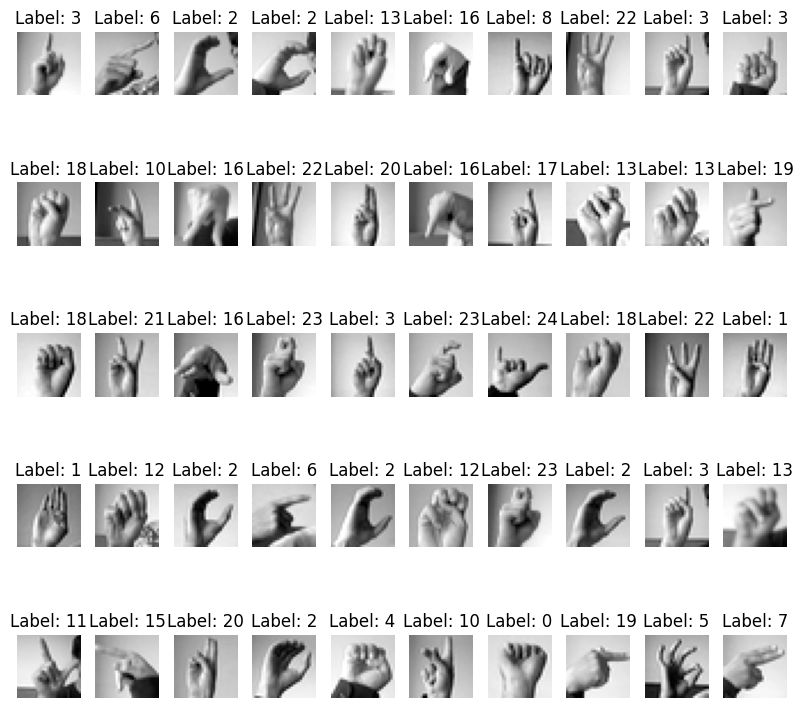

In [6]:
# Crear un mosaico de imágenes
n_rows = 5
n_cols = 10
plt.figure(figsize=(8, 8))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = X_train[i].reshape(28, 28)  # Remodelar a 28x28
    label = y_train[i]
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Convolution**

In [7]:
def Convolution2d(image, kernel, stride, padding):
    image_padded = np.pad(image, pad_width=padding, mode='constant', constant_values=0)

    tam_out_height = int(((image_padded.shape[0] - kernel.shape[0]) / stride) + 1)
    tam_out_width = int(((image_padded.shape[1] - kernel.shape[1]) / stride) + 1)
    
    image_conv = np.zeros((tam_out_height, tam_out_width))

    for i in range(tam_out_height):
        for j in range(tam_out_width):
            image_conv[i, j] = np.sum(image_padded[i*stride:i*stride + kernel.shape[0], j*stride:j*stride + kernel.shape[1]] * kernel)

    return image_conv

In [8]:
def MaxPooling2D(image, pool_size, stride=None,overlap=False):
    if overlap == False:
        stride = pool_size

    out_height = int((image.shape[0] - pool_size) / stride + 1)
    out_width = int((image.shape[1] - pool_size) / stride + 1)

    image_pooled = np.zeros((out_height, out_width))

    for i in range(out_height):
        for j in range(out_width):
            image_pooled[i, j] = np.max(image[i*stride:i*stride + pool_size, j*stride:j*stride + pool_size])

    return image_pooled

## **Kernels**

In [9]:
#Kernels
kernel_identity = np.array([[0,0,0], [0,1,0], [0, 0, 0]])
kernel_blur = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])
kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernel_BottomSobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
kernel_emboss = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
kernel_leftSobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_outline = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel_rightSobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
kernel_topSobel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

## **MLP**

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, output_size, activation_function):
        super(MLP, self).__init__()
        activation_functions = {
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh(),
            "relu": nn.ReLU()
        }

        if activation_function.lower() not in activation_functions:
            raise ValueError(f"Unsupported activation function: {activation_function}")

        self.activation_function = activation_functions[activation_function.lower()]

        layers = []
        # Input Layer
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(self.activation_function)

        # Hidden Layers
        for i in range(hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(self.activation_function)

        # Output Layer
        layers.append(nn.Linear(neurons_per_layer, output_size))

        self.layers = nn.Sequential(*layers)
        self.loss_history = None

    def forward(self, x):
      output = self.layers(x)
      return output.squeeze()

    def fit(self, X_train, Y_train, epochs=3000, learning_rate=0.01):
        loss_function = nn.CrossEntropyLoss() #Internally use Softmax function
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_history = []

        for epoch in range(epochs):
          Y_pred = self.forward(X_train)
          loss = loss_function(Y_pred,Y_train.long())
          loss_history.append(loss.item())
          #if (epoch%500==0):
            #print(f"Epoch {epoch}: train loss: {loss.item()}")

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        self.loss_history = loss_history

    def predict(self, X_test):
        self.eval()

        with torch.no_grad():  # Deactive gradient calc for interference
            Y_pred = self.forward(X_test)

        probs = torch.sigmoid(Y_pred)

        labels = probs > 0.5
        return labels.int()  # Return 0 or 1

## **CNN**

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, kernel_name, pool_size, stride, padding, conv_pool_layers, hidden_layers, neurons_per_layer, output_size, activation_function):
        super(CNN, self).__init__()
        
        # Parámetros para las capas de convolución y pooling
        self.kernel_name = kernel_name
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        self.conv_pool_layers = conv_pool_layers
        
        # Calcula el tamaño de la salida después de la convolución y el pooling
        output_after_conv = self.calculate_output_size(input_size)
        
        # Capa MLP
        self.mlp = MLP(output_after_conv, hidden_layers, neurons_per_layer, output_size, activation_function)

    def calculate_output_size(self, input_size):#Solo para imagenes cuadradas
        for i in range(self.conv_pool_layers):
            output_size = ((input_size - self.kernel_name.shape[0] + 2 * self.padding) // self.stride) + 1

            output_size = ((input_size - self.pool_size) // self.pool_size) + 1

            input_size = output_size

        return output_size*output_size
    
    def process_conv_pool(self, X_train):
        X_train_conv = []
        for i in range(X_train.shape[0]):
            image = X_train[i, 1:]
            image = image.reshape(28, 28)
            
            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                
                image = image_pooled
            
            X_train_conv.append(image_pooled.flatten())

        return X_train_conv

    
    def train(self, X_train, Y_train, epochs=3000, learning_rate=0.01):
        X_train_conv = []
        for i in range(X_train.shape[0]):
            image = X_train[i].reshape(28, 28)
            
            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                
                image = image_pooled

            X_train_conv.append(image_pooled.flatten())
        
        X_train_conv = np.array(X_train_conv)
        Y_train_conv = np.array(Y_train)
        self.mlp.fit(torch.from_numpy(X_train_conv).float(), torch.from_numpy(Y_train_conv).float(), epochs, learning_rate)

    def mlp_train(self, X_train, Y_train, epochs=3000, learning_rate=0.01):
        self.mlp.fit(X_train, Y_train, epochs, learning_rate)

    def loss_history(self):
        return self.mlp.loss_history
    
    def predict(self, X_test):
        X_test_conv = []
        for i in range(X_test.shape[0]):
            image = X_test[i].reshape(28, 28)

            for _ in range(self.conv_pool_layers):
                image_conv = Convolution2d(image, self.kernel_name, self.stride, self.padding)
                image_pooled = MaxPooling2D(image_conv, self.pool_size)
                image = image_pooled

            X_test_conv.append(image_pooled.flatten())

        X_test_conv = np.array(X_test_conv)

        X_test_tensor = torch.from_numpy(X_test_conv).float()
        logits = self.mlp(X_test_tensor)
        _, predicted_labels = torch.max(logits, 1)

        return predicted_labels

## **Entrenamiento**

In [14]:
input_size = 28 # Tamaño de entrada (por ejemplo, imágenes de 28x28)
kernel_name = kernel_rightSobel
pool_size = 2
stride = 1
padding = 1
conv_pool_layers = 1

hidden_layers = 1
neurons_per_layer = 90
output_size = 25
activation_function = 'relu'

model = CNN(input_size, kernel_name, pool_size, stride, padding, conv_pool_layers, hidden_layers, neurons_per_layer, output_size, activation_function)

In [15]:
model.train(X_train, y_train, epochs=1000, learning_rate=0.01)

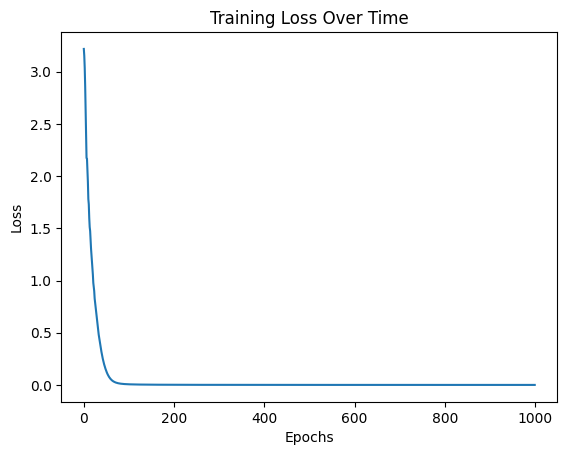

Accuracy: 75.13%


In [16]:
# Graficar la pérdida
plt.plot(model.mlp.loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

def calculate_accuracy(model, X_test, Y_test):
    predictions = model.predict(X_test)

    if not isinstance(predictions, np.ndarray):
        predictions = predictions.numpy()
    if not isinstance(Y_test, np.ndarray):
        Y_test = Y_test.numpy()

    correct = (predictions == Y_test).sum().item()
    total = len(Y_test)
    accuracy = correct / total
    return accuracy

accuracy = calculate_accuracy(model, X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [17]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Real Label': y_test, 'Predicted Label': predictions.numpy()})

print(comparison)

      Real Label  Predicted Label
0              6                6
1              5                5
2             10               17
3              0                0
4              3                3
...          ...              ...
7167           1                1
7168          12               12
7169           2                2
7170           4                4
7171           2                2

[7172 rows x 2 columns]
